In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
from pathlib import Path
import math
import numpy as np
import torch
from PIL import Image
from nerfstudio.utils.eval_utils import eval_setup
from nerfstudio.cameras.cameras import Cameras
from nerfstudio.field_components.field_heads import FieldHeadNames

In [3]:
config_path = "/root/yairshp/output_models/transformations/outputs/table/mipnerf/2023-09-27_212748/config.yml"
config_path = Path("/", *config_path.split("/"))
checkpoint_path = "/root/yairshp/output_models/transformations/outputs/table/mipnerf/2023-09-27_212748/nerfstudio_models"

fg_config_path = "/root/yairshp/output_models/transformations/outputs/ficus/mipnerf/2023-09-23_212151/config.yml"
fg_config_path = Path("/", *fg_config_path.split("/"))
fg_checkpoint_path = "/root/yairshp/output_models/transformations/outputs/ficus/mipnerf/2023-09-23_212151/nerfstudio_models"

In [4]:
_, pipeline, _, _ = eval_setup(config_path, eval_num_rays_per_chunk=None, test_mode="inference", checkpoint_path=checkpoint_path)
_, fg_pipeline, _, _ = eval_setup(fg_config_path, eval_num_rays_per_chunk=None, test_mode="inference", checkpoint_path=fg_checkpoint_path)
pipeline.datamanager.setup_train()
fg_pipeline.datamanager.setup_train()

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
/root/yairshp/output_models/transformations/outputs/table/mipnerf/2023-09-27_212748/nerfstudio_models/step-000999999.ckp
t

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
/root/yairshp/output_models/transformations/outputs/ficus/mipnerf/2023-09-23_212151/nerfstudio_models/step-000999999.ckp
t

Setting up training dataset...

Caching all 120 images.

Output()

Setting up training dataset...

Caching all 100 images.

Output()

In [5]:
current_index = torch.tensor(0)
camera_transforms = pipeline.datamanager.train_camera_optimizer(current_index.unsqueeze(dim=0))
current_camera = pipeline.datamanager.train_dataparser_outputs.cameras[current_index].to('cuda')
# modified_camera = Cameras(
#     fx=torch.tensor([[548.9938],[548.9938]]).to('cuda'),
#     fy=torch.tensor([[548.9938],[548.9938]]).to('cuda'),
#     cx=torch.tensor(256.).to('cuda'),
#     cy=torch.tensor(256.).to('cuda'),
#     camera_to_worlds=current_camera.camera_to_worlds,
#     camera_type=current_camera.camera_type,
#     times=current_camera.times
# )
# modified_camera.camera_to_worlds = current_camera.camera_to_worlds
# current_ray_bundle = modified_camera.generate_rays(torch.tensor(list(range(1))).unsqueeze(-1), camera_opt_to_camera=camera_transforms, aabb_box=None)
# current_ray_bundle = current_camera.generate_rays(torch.tensor(list(range(1))).unsqueeze(-1), camera_opt_to_camera=camera_transforms, aabb_box=None)

In [6]:
# print(current_camera.camera_to_worlds.shape, modified_camera.camera_to_worlds.shape)
# current_ray_bundle = current_camera.generate_rays(torch.tensor(list(range(1))).unsqueeze(-1), camera_opt_to_camera=camera_transforms, aabb_box=None)
# modified_camera.camera_to_worlds = current_camera.camera_to_worlds
# modified_camera.camera_to_worlds

In [7]:
fg_camera_transformations = camera_transforms.clone()
dummy = torch.tensor([[[0., 0., 0., 1.]]], device='cuda')
fg_camera_transformations = torch.cat((fg_camera_transformations, dummy), dim=1)
fg_camera_transformations

tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], device='cuda:0')

In [8]:
fg_translation = fg_camera_transformations.clone()
fg_translation[0][0][3] = 0.
fg_translation[0][1][3] = 1.33
fg_translation[0][2][3] = 0.

fg_scale = fg_camera_transformations.clone()
fg_scale[0][0][0] = 1.
fg_scale[0][1][1] = 1.
fg_scale[0][2][2] = 1.

fg_rotation_z = fg_camera_transformations.clone()
# fg_rotation_z[0][0][0] = math.cos(math.pi / 4)
# fg_rotation_z[0][1][1] = math.cos(math.pi / 4)
# fg_rotation_z[0][0][1] = math.sin(math.pi / 4)
# fg_rotation_z[0][1][0] = -math.sin(math.pi / 4)

fg_transformations = fg_rotation_z @ fg_scale @ fg_translation @ fg_camera_transformations
# fg_transformations_c2w = fg_rotation_z @ fg_scale @ fg_translation @ modified_camera.camera_to_worlds
# fg_transformations = fg_transformations[:, :-1, :]
# fg_transformations
# modified_camera.camera_to_worlds.shape

In [9]:
fg_transformations

tensor([[[1.1000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.1000, 0.0000, 1.4630],
         [0.0000, 0.0000, 1.1000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000]]], device='cuda:0')

In [10]:
current_camera.camera_to_worlds.shape, dummy.shape

(torch.Size([3, 4]), torch.Size([1, 1, 4]))

In [11]:
# torch.cat((current_camera.camera_to_worlds, torch.tensor([[0., 0., 0., 1.]], device='cuda')), dim=0)

In [12]:
current_ray_bundle = current_camera.generate_rays(torch.tensor(list(range(1))).unsqueeze(-1), camera_opt_to_camera=camera_transforms, aabb_box=None)
modified_camera = current_camera
modified_camera.camera_to_worlds = (fg_transformations @ torch.cat((current_camera.camera_to_worlds, torch.tensor([[0., 0., 0., 1.]], device='cuda')), dim=0))[:, :-1, :]
# modified_camera.camera_to_worlds = fg_transformations @ modified_camera.camera_to_worlds[1]
fg_ray_bundle = modified_camera.generate_rays(torch.tensor(list(range(1))).unsqueeze(-1), camera_opt_to_camera=camera_transforms, aabb_box=None)

In [13]:
with torch.no_grad():
    outputs = pipeline.model.get_outputs_for_camera_ray_bundle(current_ray_bundle, fg_pipeline=fg_pipeline, fg_camera_ray_bundle=fg_ray_bundle)

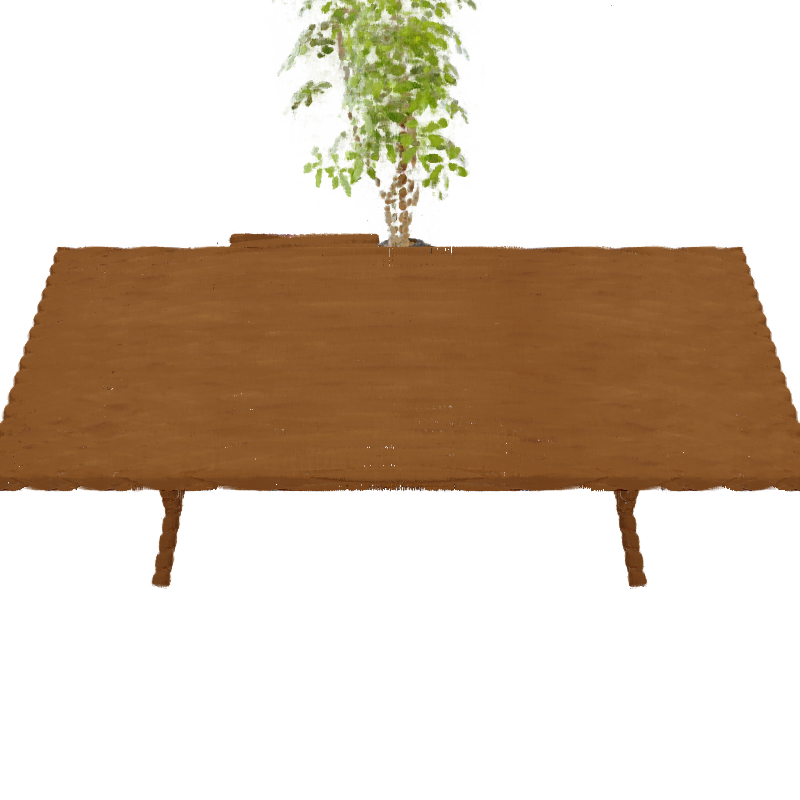

In [14]:
image = (outputs['rgb_coarse'].cpu().numpy() * 255).astype(np.uint8)
image = Image.fromarray(image)
image


In [15]:
# num_rays_per_chunk = pipeline.model.config.eval_num_rays_per_chunk
# image_height, image_width = current_ray_bundle.origins.shape[:2]
# num_rays = len(current_ray_bundle)
# # outputs_lists = defaultdict(list)
# rgb_fine_outputs = []
# with torch.no_grad():
#     for i in range(0, num_rays, num_rays_per_chunk):
#         start_idx = i
#         end_idx = i + num_rays_per_chunk
#         ray_bundle = current_ray_bundle.get_row_major_sliced_ray_bundle(start_idx, end_idx)
#         if pipeline.model.collider is not None:
#             ray_bundle = pipeline.model.collider(ray_bundle)
#         if pipeline.model.field is None:
#                 raise ValueError("populate_fields() must be called before get_outputs")
#         ray_samples_uniform = pipeline.model.sampler_uniform(ray_bundle)
#         field_outputs_coarse = pipeline.model.field.forward(ray_samples_uniform)
#         weights_coarse = ray_samples_uniform.get_weights(field_outputs_coarse[FieldHeadNames.DENSITY])
#         rgb_coarse = pipeline.model.renderer_rgb(rgb=field_outputs_coarse[FieldHeadNames.RGB], weights=weights_coarse)
#         ray_samples_pdf = pipeline.model.sampler_pdf(ray_bundle, ray_samples_uniform, weights_coarse)
#         field_outputs_fine = pipeline.model.field.forward(ray_samples_pdf)
#         weights_fine = ray_samples_pdf.get_weights(field_outputs_fine[FieldHeadNames.DENSITY])
#         rgb_fine = pipeline.model.renderer_rgb(
#             rgb=field_outputs_fine[FieldHeadNames.RGB],
#             weights=weights_fine,
#         )
#         rgb_fine_outputs.append(rgb_fine)
#     rgb_fine = torch.cat(rgb_fine_outputs).view(image_height, image_width, -1)

In [16]:
# image = (rgb_fine.cpu().numpy() * 255).astype(np.uint8)
# image = Image.fromarray(image)
# image